In [1]:
from transformers import GPT2LMHeadModel

2024-11-18 14:32:48.575957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 14:32:48.627205: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 14:32:48.629116: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.5/lib64
2024-11-18 14:32:48.629125: I tensorflow/compiler/xla/stream_execut

In [2]:
path = './model'
model_hf = GPT2LMHeadModel.from_pretrained(path)
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [3]:
sd_hf['transformer.wpe.weight'].view(-1)[:20]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

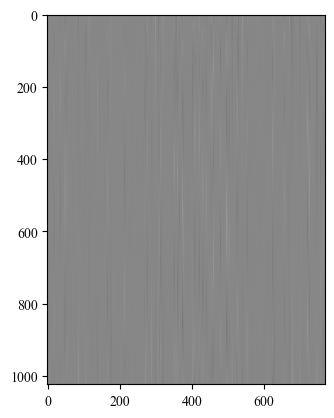

In [4]:
import matplotlib.pyplot as plt
plt.imshow(sd_hf['transformer.wpe.weight'], cmap='gray')

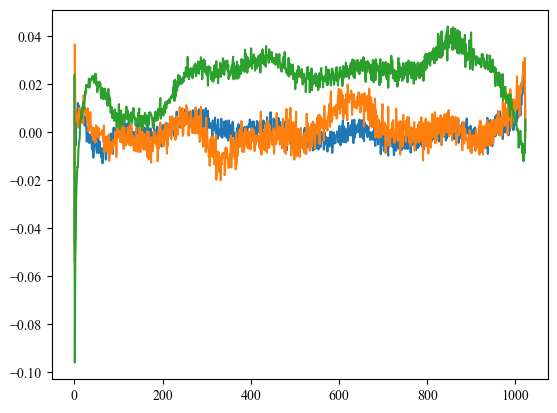

In [5]:
plt.plot(sd_hf['transformer.wpe.weight'][:, 150])
plt.plot(sd_hf['transformer.wpe.weight'][:, 200])
plt.plot(sd_hf['transformer.wpe.weight'][:, 250])

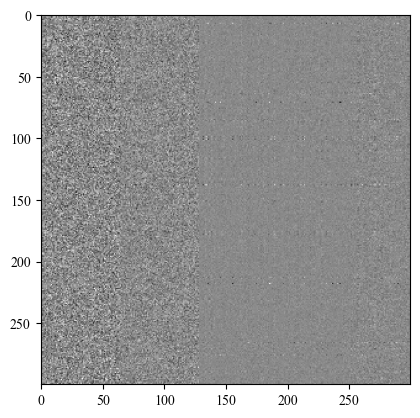

In [6]:
plt.imshow(sd_hf['transformer.h.1.attn.c_attn.weight'][:300,:300],cmap='gray')

In [7]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model=path)
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[{'generated_text': "Hello, I'm a language model, but what I'm really doing is making a human-readable document. There are other languages, but those are"},
 {'generated_text': "Hello, I'm a language model, not a syntax model. That's why I like it. I've done a lot of programming projects.\n"},
 {'generated_text': "Hello, I'm a language model, and I'll do it in no time!\n\nOne of the things we learned from talking to my friend"},
 {'generated_text': "Hello, I'm a language model, not a command line tool.\n\nIf my code is simple enough:\n\nif (use (string"},
 {'generated_text': "Hello, I'm a language model, I've been using Language in all my work. Just a small example, let's see a simplified example."}]

In [8]:
# let's instead sample manually
import torch
from torch.nn import functional as F

model = GPT2LMHeadModel.from_pretrained(path)# 124M
model.eval()
model.to('cuda')
torch.manual_seed(42)
torch.cuda.manual_seed(42)
tokens =[15496,11,314,1101,257,3303,2746,11]# "Hello, I'm a language model,"
tokens =torch.tensor(tokens,dtype=torch.long)#(8,)
tokens =tokens.unsqueeze(0).repeat(5, 1)#(5，8)
x = tokens.to('cuda')

# generate!
while x.size(1) < 30:
    # forward the model to get the logits
    with torch.no_grad():#上下文管理器
        logits = model(x)[0]#(B，T,vocab_size)
        # take the logits at the last position
        logits =logits[:, -1, :]#(B，vocab_size)
        # get the probabilities
        probs =F.softmax(logits, dim=-1)
        # do top-k sampling of 50(huggingface pipeline default)
        #topk_probs here becomes(5,50),topk indices is(5，50)
        topk_probs,topk_indices =torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        ix = torch.multinomial(topk_probs, 1)#(B，1)
        # gather the corresponding indices
        xcol =torch.gather(topk_indices, -1, ix)#(B，1)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1)

# print the generated text
import tiktoken
enc= tiktoken.get_encoding('gpt2')
# print the generated text
for i in range(5):
    tokens = x[i,:30].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

> Hello, I'm a language model, not a program.

So this morning I started studying for the interview in the lab. This was not
> Hello, I'm a language model, and one of the main things that bothers me when they create languages is how easy it becomes to create something that
> Hello, I'm a language model, and I wrote it off on the grounds that a language model would make me more fluent. But I'm not
> Hello, I'm a language model, I really like languages. I like languages because like, they're good. And the way we talk about languages
> Hello, I'm a language model, a language model I'm using for data modelling. All I did was test the results and then I wrote some


In [9]:
with open('manual.txt', 'r') as f:
    text = f.read()
    data = text[:1000]# first 1,000 characters
    print(data[:100])

北 京 大 学
PEKING UNIVERSITY
北 京 ⼤ 学 研 究 ⽣ ⼿ 册
（ 2 0 2 3 版 ）
北 京 ⼤ 学 研 究 ⽣ 院
2 0 2 3 年 8 ⽉
习近平对研究生教育工作作


In [10]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

[44293, 245, 220, 12859, 105, 36469, 100, 10263, 255, 99, 198, 11401, 37286, 49677, 9050, 198, 44293, 245, 220, 12859, 105, 2343, 120, 97]


In [11]:
import torch
buf = torch.tensor(tokens[:24 + 1])
x= buf[:-1].view(4, 6)
y= buf[1:].view(4, 6)
print(x)
print(y)

tensor([[44293,   245,   220, 12859,   105, 36469],
        [  100, 10263,   255,    99,   198, 11401],
        [37286, 49677,  9050,   198, 44293,   245],
        [  220, 12859,   105,  2343,   120,    97]])
tensor([[  245,   220, 12859,   105, 36469,   100],
        [10263,   255,    99,   198, 11401, 37286],
        [49677,  9050,   198, 44293,   245,   220],
        [12859,   105,  2343,   120,    97, 10263]])


In [12]:
print(sd_hf["lm_head.weight"].shape)
print(sd_hf["transformer.wte.weight"].shape)

torch.Size([50257, 768])
torch.Size([50257, 768])


In [13]:
(sd_hf["lm_head.weight"] == sd_hf["transformer.wte.weight"]).all()

tensor(True)

In [14]:
print(sd_hf["lm_head.weight"].data_ptr())
print(sd_hf["transformer.wte.weight"].data_ptr())

133901202751552
133901202751552


In [15]:
# standard deviation grows inside the residual stream
x= torch.zeros(768)
n=100 #e.g.100 layers
for i in range(n):
    x += n**-0.5 * torch.randn(768)

print(x.std())

tensor(0.9850)


In [16]:
import torch

# super simple little MLP
net = torch.nn.Sequential(
    torch.nn.Linear(16,32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 1)
)
torch.random.manual_seed(42)
x= torch.randn(4, 16)
y= torch.randn(4, 1)
net.zero_grad()
yhat = net(x)
loss = torch.nn.functional.mse_loss(yhat, y)
loss.backward()
print(net[0].weight.grad.view(-1)[:10])

# the loss objective here is(due to readuction='mean')#L= 1/4 *[
# L = 1/4 * [
# (y[0]- yhat[0])**2 +
# (y[1]- yhat[1])**2 +
# (y[2]- yhat [2])**2 +
# (y[3]- yhat [3] )**2
# ]
# NOTE: 1/4!

tensor([ 0.0280,  0.0069, -0.0034, -0.0073, -0.0051,  0.0042,  0.0109,  0.0212,
         0.0247,  0.0105])


In [17]:
# now let's do it with grad_accum_ steps of 4, and B=1
# the loss objective here is different because
#accumulation in gradient <---> SUM in loss
# i.e. we instead get:
# L0 = (y[0] - yhat[0])**2
# L1 = (y[1] - yhat[1])**2
# L2 = (y[2] - yhat[2])**2
# L3 = (y[3] - yhat[3])**2
#L = L0 + L1 + L2 + L3
# NOTE: the "normalizer" of 1/4 is lost
net.zero_grad()
for i in range(4):
    yhat = net(x[i])
    loss = torch.nn.functional.mse_loss(yhat, y[i])
    loss = loss / 4
    loss.backward()
print(net[0].weight.grad.view(-1)[:10])

tensor([ 0.0280,  0.0069, -0.0034, -0.0073, -0.0051,  0.0042,  0.0109,  0.0212,
         0.0247,  0.0105])


Min Train Loss: 6.98211
Min Validation Loss: 10.9511
Max Hellaswag eval: 0.2487


/tmp/ipykernel_4098021/3131048263.py:62: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0.0, 4.0)


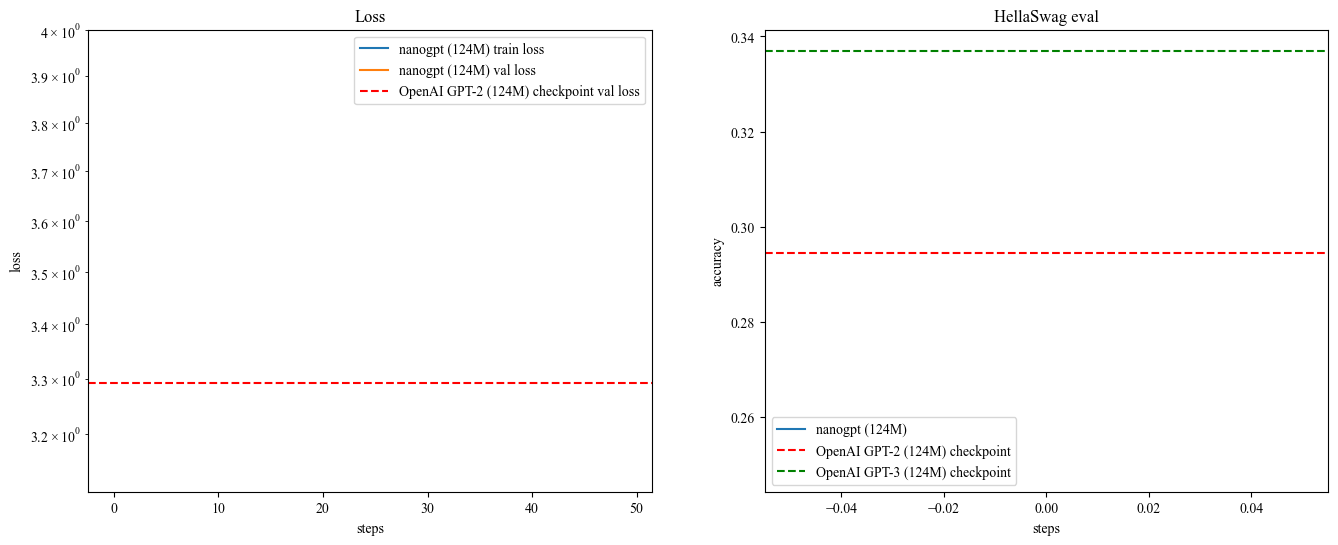

In [ ]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))